<a href="https://colab.research.google.com/github/AdamRolander/RAG-Experiments/blob/main/RapidFire_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval-First RAG Experimentation Challenge
### Custom ArXiv Scientific Literature Corpus with Multi-Query Evaluation

**Author:** Adam Rolander
**Competition:** RapidFire AI - RAG Track  
**Date:** 19 January 2026


##Synthesize Dataset

### Environment Setup & Dependencies

This cell installs all required packages and imports necessary libraries for the RAG dataset creation pipeline.

**Key Dependencies:**
- **Unsloth**: Fast inference for Llama 3.1 model (query generation)
- **Scikit-learn**: TF-IDF computation for hard negative mining
- **HuggingFace Datasets**: Streaming ArXiv abstract corpus https://huggingface.co/datasets/gfissore/arxiv-abstracts-2021

**Reproducibility:** Random seeds are set to ensure consistent sampling across runs.

---

In [1]:
# Install dependencies
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" -q
!pip install --no-deps xformers trl peft accelerate bitsandbytes -q
!pip install scikit-learn -q

import json
import random
import torch
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict, Counter
from datasets import load_dataset
from unsloth import FastLanguageModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("✓ All dependencies installed")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✓ All dependencies installed


### Dataset Configuration

Define the target corpus structure and evaluation set parameters.

**Design Decisions:**
- **4 domains** (CS, EESS, Math, Statistics) for balanced STEM coverage
- **40,000 documents** with perfect balance (10k per domain)
- **1,000 evaluation queries** generated from 500 documents (2 query types each)

This configuration ensures:
- No domain bias in evaluation metrics
- Sufficient scale for robust retrieval testing
- Query diversity for testing semantic vs. lexical approaches

---

In [2]:
# --- CONFIGURATION ---
TARGET_DOMAINS = ['cs', 'eess', 'math', 'stat']
TOTAL_TARGET = 40000  # 10,000 per domain for robust evaluation
PER_DOMAIN_LIMIT = TOTAL_TARGET // len(TARGET_DOMAINS)
EVAL_SAMPLE_SIZE = 500  # Will generate 2 queries per doc = 1000 total queries

print(f"Target corpus size: {TOTAL_TARGET:,}")
print(f"Domains: {', '.join(TARGET_DOMAINS)}")
print(f"Per-domain limit: {PER_DOMAIN_LIMIT:,}")
print(f"Eval documents: {EVAL_SAMPLE_SIZE}")
print(f"Total eval queries: {EVAL_SAMPLE_SIZE * 2}")
print(f"\n✓ Configuration optimized for available data")

Target corpus size: 40,000
Domains: cs, eess, math, stat
Per-domain limit: 10,000
Eval documents: 500
Total eval queries: 1000

✓ Configuration optimized for available data


### Step 1: Corpus Creation with Balanced Sampling

Stream the ArXiv 2021 abstracts dataset and extract exactly 10,000 papers from each target domain.

**Sampling Strategy:**
- Parse primary category from ArXiv metadata (e.g., `cs.LG` → `cs`)
- Enforce strict per-domain limits to prevent imbalance
- Save to JSONL format for efficient loading

**Output:** `working_corpus.jsonl` (40,000 scientific abstracts)

---

In [3]:
# --- STEP 1: BALANCED CORPUS CREATION ---
print(f"\n{'='*60}")
print(f"STEP 1: Creating balanced corpus ({PER_DOMAIN_LIMIT:,} per domain)")
print(f"{'='*60}\n")

dataset = load_dataset("gfissore/arxiv-abstracts-2021", split="train", streaming=True)
counts = defaultdict(int)
working_docs = []
MIN_ABSTRACT_LENGTH = 20  # Filter out very short/broken abstracts

with open("working_corpus.jsonl", "w") as f:
    for entry in tqdm(dataset, desc="Sampling corpus", total=TOTAL_TARGET):
        if len(working_docs) >= TOTAL_TARGET:
            break

        # Extract primary category prefix (e.g., 'cs' from 'cs.LG')
        cats_list = entry["categories"][0].split() if isinstance(entry["categories"][0], str) else entry["categories"]
        primary_cat = cats_list[0].split('.')[0].split('-')[0]

        # Check domain and count, AND filter by abstract length
        abstract_word_count = len(entry["abstract"].split())

        if (primary_cat in TARGET_DOMAINS
            and counts[primary_cat] < PER_DOMAIN_LIMIT
            and abstract_word_count >= MIN_ABSTRACT_LENGTH):

            doc = {
                "id": str(entry["id"]),
                "title": entry["title"],
                "abstract": entry["abstract"],
                "categories": entry["categories"]
            }
            working_docs.append(doc)
            counts[primary_cat] += 1
            f.write(json.dumps(doc) + "\n")

print(f"\n✓ Corpus created: {len(working_docs):,} documents")
print(f"✓ All abstracts have ≥{MIN_ABSTRACT_LENGTH} words")
print(f"✓ Domain distribution:")
for domain in sorted(TARGET_DOMAINS):
    print(f"  {domain:12s}: {counts[domain]:,}")

with open('checkpoint_corpus.pkl', 'wb') as f:
    pickle.dump({
        'working_docs': working_docs,
        'counts': dict(counts)
    }, f)
print("✓ Checkpoint saved: corpus creation complete")


STEP 1: Creating balanced corpus (10,000 per domain)



Sampling corpus:   0%|          | 0/40000 [00:00<?, ?it/s]


✓ Corpus created: 40,000 documents
✓ All abstracts have ≥20 words
✓ Domain distribution:
  cs          : 10,000
  eess        : 10,000
  math        : 10,000
  stat        : 10,000
✓ Checkpoint saved: corpus creation complete


### Step 2: Corpus Statistical Analysis

Compute comprehensive statistics on the corpus to understand document characteristics and validate data quality.

**Metrics Computed:**
- Abstract length distribution (mean, std, range)
- Title length statistics
- Domain balance verification
- Sub-category diversity

These statistics inform chunking strategy design (e.g., choosing chunk sizes based on average abstract length).

**Output:** `corpus_statistics.json`

---

In [4]:
# --- STEP 2: COMPUTE CORPUS STATISTICS ---
print(f"\n{'='*60}")
print(f"STEP 2: Computing corpus statistics")
print(f"{'='*60}\n")

corpus_df = pd.read_json("working_corpus.jsonl", lines=True)

# Compute lengths
corpus_df['abstract_length'] = corpus_df['abstract'].str.split().str.len()
corpus_df['title_length'] = corpus_df['title'].str.split().str.len()

# Extract primary domain for distribution
def get_primary_domain(cats):
    cats_list = cats[0].split() if isinstance(cats[0], str) else cats
    return cats_list[0].split('.')[0].split('-')[0]

corpus_df['primary_domain'] = corpus_df['categories'].apply(get_primary_domain)

# Compute detailed statistics
stats = {
    "total_documents": len(corpus_df),
    "abstract_length": {
        "mean": float(corpus_df['abstract_length'].mean()),
        "std": float(corpus_df['abstract_length'].std()),
        "min": int(corpus_df['abstract_length'].min()),
        "max": int(corpus_df['abstract_length'].max()),
        "median": float(corpus_df['abstract_length'].median())
    },
    "title_length": {
        "mean": float(corpus_df['title_length'].mean()),
        "std": float(corpus_df['title_length'].std()),
        "min": int(corpus_df['title_length'].min()),
        "max": int(corpus_df['title_length'].max())
    },
    "domain_distribution": dict(corpus_df['primary_domain'].value_counts().to_dict()),
    "unique_categories": len(set(cat for cats in corpus_df['categories'] for cat in cats[0].split())),
}

# Save statistics
with open("corpus_statistics.json", "w") as f:
    json.dump(stats, f, indent=2)

# Print summary
print(f"✓ Total Documents: {stats['total_documents']:,}")
print(f"\n  Abstract Length Statistics:")
print(f"    Mean: {stats['abstract_length']['mean']:.1f} words")
print(f"    Std:  {stats['abstract_length']['std']:.1f} words")
print(f"    Range: {stats['abstract_length']['min']}-{stats['abstract_length']['max']} words")
print(f"    Median: {stats['abstract_length']['median']:.1f} words")
print(f"\n  Unique Sub-categories: {stats['unique_categories']}")
print(f"\n✓ Statistics saved to 'corpus_statistics.json'")


STEP 2: Computing corpus statistics

✓ Total Documents: 40,000

  Abstract Length Statistics:
    Mean: 134.4 words
    Std:  60.1 words
    Range: 20-457 words
    Median: 131.0 words

  Unique Sub-categories: 151

✓ Statistics saved to 'corpus_statistics.json'


### Step 3: Load Language Model for Query Synthesis

Load **Llama 3.1 8B Instruct** in 4-bit quantization for efficient query generation on Colab's free-tier GPU.

**Model Choice Rationale:**
- Instruction-tuned for following specific prompts
- 4-bit quantization enables T4 GPU usage
- Strong performance on technical/academic content

This model will generate diverse, realistic queries that require semantic understanding to answer correctly.

---

In [5]:
# --- STEP 3: LOAD MODEL & TOKENIZER ---
print(f"\n{'='*60}")
print(f"STEP 3: Loading LLM for synthetic query generation")
print(f"{'='*60}\n")

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/meta-llama-3.1-8b-instruct-bnb-4bit",
    max_seq_length=2048,
    load_in_4bit=True,
)
FastLanguageModel.for_inference(model)

print("✓ Model loaded successfully")


STEP 3: Loading LLM for synthetic query generation

==((====))==  Unsloth 2025.12.8: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✓ Model loaded successfully


### Step 4: Multi-Style Query Generation

Generate **2 query types** per document to test retrieval robustness:

1. **Technical Queries**: Focus on methodology, approach, and findings
2. **Application Queries**: Focus on use cases, implications, and practical impact

**Generation Parameters:**
- `temperature=0.7` for diversity (avoid repetitive patterns)
- `top_p=0.9` for quality control
- Validation: Ensure queries end with `?`

This dual-query approach tests whether retrieval systems work across different information needs.

**Output:** 1,000 queries (500 docs × 2 types)

---

In [6]:
# --- STEP 4: GENERATE MULTI-STYLE QUERIES (STRATIFIED SAMPLING) ---
print(f"\n{'='*60}")
print(f"STEP 4: Generating {EVAL_SAMPLE_SIZE * 2} queries (2 styles × {EVAL_SAMPLE_SIZE} docs)")
print(f"{'='*60}\n")

# STRATIFIED SAMPLING: Equal number of docs per domain
docs_per_domain = EVAL_SAMPLE_SIZE // len(TARGET_DOMAINS)  # 500 // 4 = 125
print(f"Sampling {docs_per_domain} documents per domain for balanced evaluation\n")

# Group documents by domain
from collections import defaultdict
docs_by_domain = defaultdict(list)

for doc in working_docs:
    cats_list = doc["categories"][0].split() if isinstance(doc["categories"][0], str) else doc["categories"]
    primary_cat = cats_list[0].split('.')[0].split('-')[0]
    docs_by_domain[primary_cat].append(doc)

print("\n✓ Domain availability check:")
for domain in TARGET_DOMAINS:
    available = len(docs_by_domain[domain])
    needed = docs_per_domain
    status = "✓" if available >= needed else "✗ ERROR"
    print(f"  {domain:8s}: {available:,} available, {needed} needed {status}")

    if available < needed:
        raise ValueError(f"Domain '{domain}' only has {available} docs, need {needed}!")

print(f"✓ All domains have sufficient documents for stratified sampling\n")

# Sample equally from each domain
eval_docs = []
for domain in TARGET_DOMAINS:
    domain_sample = random.sample(docs_by_domain[domain], docs_per_domain)
    eval_docs.extend(domain_sample)
    print(f"  ✓ Sampled {len(domain_sample)} docs from {domain} domain")

print(f"\n✓ Total eval documents: {len(eval_docs)} (perfectly balanced)")

# Define query styles
query_styles = [
    {
        "name": "technical",
        "prompt": "Write a specific technical question about the methodology, approach, or findings in this abstract. The question should require understanding the abstract to answer."
    },
    {
        "name": "application",
        "prompt": "Write a question about the practical applications, implications, or use cases of this research. Focus on how this work could be applied or what problems it solves."
    }
]

eval_set = []

# Generate queries with progress bar
for doc in tqdm(eval_docs, desc="Generating queries"):
    for style in query_styles:
        # Construct prompt
        prompt = (
            "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n"
            "You are a research assistant. Output ONLY a single question.<|eot_id|>"
            "<|start_header_id|>user<|end_header_id|>\n\n"
            f"Abstract: {doc['abstract']}\n\n"
            f"Task: {style['prompt']}<|eot_id|>"
            "<|start_header_id|>assistant<|end_header_id|>\n\n"
        )

        # Generate
        inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
        outputs = model.generate(
            **inputs,
            max_new_tokens=60,
            temperature=0.7,
            do_sample=True,
            top_p=0.9
        )

        # Extract and clean query
        full_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        raw_query = full_output.split("assistant")[-1].strip()
        clean_query = raw_query.split('\n')[0].strip()

        # Basic validation: ensure it's a question
        if not clean_query.endswith('?'):
            clean_query += '?'

        # Extract primary category
        cats_list = doc["categories"][0].split() if isinstance(doc["categories"][0], str) else doc["categories"]
        primary_category = cats_list[0]

        eval_set.append({
            "query": clean_query,
            "query_type": style["name"],
            "ground_truth_id": doc["id"],
            "ground_truth_category": primary_category,
            "ground_truth_title": doc["title"]
        })

print(f"\n✓ Generated {len(eval_set)} queries")
print(f"  Technical queries: {sum(1 for q in eval_set if q['query_type'] == 'technical')}")
print(f"  Application queries: {sum(1 for q in eval_set if q['query_type'] == 'application')}")

# Check for duplicate queries
original_count = len(eval_set)
seen_queries = set()
deduped_eval_set = []

for item in eval_set:
    query_lower = item['query'].lower().strip()
    if query_lower not in seen_queries:
        seen_queries.add(query_lower)
        deduped_eval_set.append(item)

eval_set = deduped_eval_set
duplicates_removed = original_count - len(eval_set)

if duplicates_removed > 0:
    print(f"\n⚠️ Removed {duplicates_removed} duplicate queries")
else:
    print(f"\n✓ No duplicate queries detected")

# Verify domain balance in eval set
domain_counts = Counter(q['ground_truth_category'].split('.')[0] for q in eval_set)
print(f"\n✓ Domain distribution in eval set:")
for domain in TARGET_DOMAINS:
    count = domain_counts.get(domain, 0)
    print(f"  {domain:8s}: {count} queries ({100*count/len(eval_set):.1f}%)")

# Sample queries
print(f"\nSample Technical Query:")
tech_sample = next(q for q in eval_set if q['query_type'] == 'technical')
print(f"  Q: {tech_sample['query']}")

print(f"\nSample Application Query:")
app_sample = next(q for q in eval_set if q['query_type'] == 'application')
print(f"  Q: {app_sample['query']}")

# Checkpoint: Save eval set progress
with open('checkpoint_eval_set.pkl', 'wb') as f:
    pickle.dump(eval_set, f)
print("✓ Checkpoint saved: query generation complete")


STEP 4: Generating 1000 queries (2 styles × 500 docs)

Sampling 125 documents per domain for balanced evaluation


✓ Domain availability check:
  cs      : 10,000 available, 125 needed ✓
  eess    : 10,000 available, 125 needed ✓
  math    : 10,000 available, 125 needed ✓
  stat    : 10,000 available, 125 needed ✓
✓ All domains have sufficient documents for stratified sampling

  ✓ Sampled 125 docs from cs domain
  ✓ Sampled 125 docs from eess domain
  ✓ Sampled 125 docs from math domain
  ✓ Sampled 125 docs from stat domain

✓ Total eval documents: 500 (perfectly balanced)


Generating queries:   0%|          | 0/500 [00:00<?, ?it/s]


✓ Generated 1000 queries
  Technical queries: 500
  Application queries: 500

✓ No duplicate queries detected

✓ Domain distribution in eval set:
  cs      : 250 queries (25.0%)
  eess    : 250 queries (25.0%)
  math    : 226 queries (22.6%)
  stat    : 250 queries (25.0%)

Sample Technical Query:
  Q: What is the specific mechanism by which the Mirroring Neural Network architecture achieves the reconstruction of the original high-dimensional input vector from the reduced low-dimensional data, and how does this reconstruction process contribute to the classification of patterns?

Sample Application Query:
  Q: What are the potential real-world applications of the Mirroring Neural Network architecture, and how could its ability to perform non-linear dimensionality reduction and object recognition be leveraged to improve image and pattern classification in fields such as computer vision, data compression, or cybersecurity?
✓ Checkpoint saved: query generation complete


### Step 5: Hard Negative Mining via TF-IDF

For each query, identify **5 hard negatives** — documents that are semantically similar but do NOT answer the query.

**Why Hard Negatives Matter:**
- Test whether rerankers can distinguish true positives from near-misses
- Prevent retrieval systems from succeeding via simple keyword matching
- Enable evaluation of semantic understanding

**Method:** TF-IDF cosine similarity to find topically similar but incorrect documents.

**Output:** Each query now has `ground_truth_id` + 5 `hard_negative_ids`

---

In [7]:
# --- STEP 5: GENERATE HARD NEGATIVES ---
print(f"\n{'='*60}")
print(f"STEP 5: Computing hard negatives via TF-IDF similarity")
print(f"{'='*60}\n")

# Prepare corpus texts and IDs
corpus_texts = [doc['abstract'] for doc in working_docs]
corpus_ids = [doc['id'] for doc in working_docs]
id_to_idx = {doc_id: idx for idx, doc_id in enumerate(corpus_ids)}

# Compute TF-IDF matrix
print("Computing TF-IDF vectors...")
vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    ngram_range=(1, 2)
)
tfidf_matrix = vectorizer.fit_transform(corpus_texts)

print(f"✓ TF-IDF matrix shape: {tfidf_matrix.shape}")

# For each eval item, find hard negatives
print("\nFinding hard negatives for each query...")
for eval_item in tqdm(eval_set):
    # Get ground truth document index
    ground_truth_idx = id_to_idx[eval_item['ground_truth_id']]

    # Compute query similarity to all documents
    query_vec = vectorizer.transform([eval_item['query']])
    similarities = cosine_similarity(query_vec, tfidf_matrix)[0]

    # Get top similar documents (excluding ground truth)
    # We want documents that are similar but NOT the answer
    similar_indices = similarities.argsort()[::-1]

    # Select top 5 hard negatives (semantically similar but wrong)
    hard_negs = []
    for idx in similar_indices:
        if idx != ground_truth_idx and len(hard_negs) < 5:
            hard_negs.append(corpus_ids[idx])

    eval_item['hard_negative_ids'] = hard_negs

print(f"\n✓ Hard negatives computed for all {len(eval_set)} queries")

# Verify
sample = eval_set[0]
print(f"\nSample Hard Negatives:")
print(f"  Query: {sample['query'][:80]}...")
print(f"  Ground Truth: {sample['ground_truth_id']}")
print(f"  Hard Negatives: {sample['hard_negative_ids'][:3]}")


STEP 5: Computing hard negatives via TF-IDF similarity

Computing TF-IDF vectors...
✓ TF-IDF matrix shape: (40000, 2000)

Finding hard negatives for each query...


  0%|          | 0/1000 [00:00<?, ?it/s]


✓ Hard negatives computed for all 1000 queries

Sample Hard Negatives:
  Query: What is the specific mechanism by which the Mirroring Neural Network architectur...
  Ground Truth: 0712.0932
  Hard Negatives: ['2002.02063', '1712.03627', '0901.3494']


### Step 6: Query Analysis & Metadata Export

Compute statistics on the generated queries to validate quality and diversity.

**Metrics:**
- Query length distribution
- Balance between technical/application queries
- Per-domain coverage in evaluation set

**Outputs:**
- `rag_eval_set.json` (1,000 queries with metadata)
- `query_statistics.json` (statistical summary)

---

In [8]:
# --- STEP 6: COMPUTE QUERY STATISTICS & SAVE ---
print(f"\n{'='*60}")
print(f"STEP 6: Computing query statistics and saving eval set")
print(f"{'='*60}\n")

# Compute query lengths
query_lengths = [len(q['query'].split()) for q in eval_set]

query_stats = {
    "total_queries": len(eval_set),
    "queries_per_type": {
        "technical": sum(1 for q in eval_set if q['query_type'] == 'technical'),
        "application": sum(1 for q in eval_set if q['query_type'] == 'application')
    },
    "query_length": {
        "mean": float(np.mean(query_lengths)),
        "std": float(np.std(query_lengths)),
        "min": int(np.min(query_lengths)),
        "max": int(np.max(query_lengths)),
        "median": float(np.median(query_lengths))
    },
    "queries_per_category": dict(Counter(q['ground_truth_category'].split('.')[0]
                                         for q in eval_set).most_common(10)),
    "hard_negatives_per_query": 5
}

# Save eval set
with open("rag_eval_set.json", "w") as f:
    json.dump(eval_set, f, indent=2)

# Save query statistics
with open("query_statistics.json", "w") as f:
    json.dump(query_stats, f, indent=2)

print(f"✓ Eval set saved: {len(eval_set)} queries")
print(f"\n  Query Length Statistics:")
print(f"    Mean: {query_stats['query_length']['mean']:.1f} words")
print(f"    Std:  {query_stats['query_length']['std']:.1f} words")
print(f"    Range: {query_stats['query_length']['min']}-{query_stats['query_length']['max']} words")
print(f"\n  Top Categories in Eval Set:")
for cat, count in list(query_stats['queries_per_category'].items())[:5]:
    print(f"    {cat}: {count}")

print(f"\n✓ Query statistics saved to 'query_statistics.json'")


STEP 6: Computing query statistics and saving eval set

✓ Eval set saved: 1000 queries

  Query Length Statistics:
    Mean: 38.8 words
    Std:  7.5 words
    Range: 5-56 words

  Top Categories in Eval Set:
    cs: 250
    eess: 250
    stat: 250
    math: 226
    math-ph: 24

✓ Query statistics saved to 'query_statistics.json'


### Step 7: Dataset Validation & Integrity Checks

Run comprehensive validation to ensure dataset quality before experimentation.

**Validation Checks:**
1. Corpus size matches configuration (40,000 docs)
2. All ground truth IDs exist in corpus
3. All hard negative IDs exist in corpus
4. Queries are well-formed (contain `?`)
5. Eval set has correct size (1,000 queries)

**Expected Result:** All checks should pass with ✓

If any validation fails, the dataset should be regenerated.

---

In [9]:
# --- STEP 7: VALIDATION & SUMMARY ---
print(f"\n{'='*60}")
print(f"DATASET CREATION COMPLETE - VALIDATION SUMMARY")
print(f"{'='*60}\n")

# Load all files to verify
corpus_df = pd.read_json("working_corpus.jsonl", lines=True, dtype={'id': str})
eval_df = pd.DataFrame(eval_set)
corpus_stats = json.load(open("corpus_statistics.json"))
query_stats = json.load(open("query_statistics.json"))

# Validation checks
print("✓ VALIDATION CHECKS:")
print(f"  1. Corpus size: {len(corpus_df):,} documents")
print(f"  2. Eval queries: {len(eval_df):,}")
print(f"  3. Ground truth coverage: {len(set(eval_df['ground_truth_id']))}/{EVAL_SAMPLE_SIZE} unique docs")

# Check that all ground truth IDs exist in corpus
missing_ids = set(eval_df['ground_truth_id']) - set(corpus_df['id'])
print(f"  4. Missing ground truth IDs: {len(missing_ids)} {'✗ ERROR' if missing_ids else '✓'}")

# Check hard negatives exist
all_hard_negs = [hn for q in eval_set for hn in q['hard_negative_ids']]
missing_hard_negs = set(all_hard_negs) - set(corpus_df['id'])
print(f"  5. Missing hard negative IDs: {len(missing_hard_negs)} {'✗ ERROR' if missing_hard_negs else '✓'}")

# Check query quality
queries_with_question_marks = sum(1 for q in eval_set if '?' in q['query'])
print(f"  6. Queries with '?': {queries_with_question_marks}/{len(eval_set)} ({100*queries_with_question_marks/len(eval_set):.1f}%)")

print(f"\n✓ FILES CREATED:")
print(f"  • working_corpus.jsonl        ({len(corpus_df):,} documents)")
print(f"  • rag_eval_set.json           ({len(eval_df):,} queries)")
print(f"  • corpus_statistics.json      (corpus metadata)")
print(f"  • query_statistics.json       (query metadata)")

print(f"\n{'='*60}")
print(f"SUCCESS! Dataset ready for RAG experimentation")
print(f"{'='*60}\n")

# Print some example queries for manual inspection
print("EXAMPLE QUERIES FOR MANUAL INSPECTION:\n")
for i, q in enumerate(eval_df.sample(3).to_dict('records')):
    print(f"{i+1}. [{q['query_type'].upper()}] {q['query']}")
    print(f"   Ground Truth: {q['ground_truth_id']} ({q['ground_truth_category']})")
    print(f"   Hard Negatives: {', '.join(q['hard_negative_ids'][:2])}...\n")


DATASET CREATION COMPLETE - VALIDATION SUMMARY

✓ VALIDATION CHECKS:
  1. Corpus size: 40,000 documents
  2. Eval queries: 1,000
  3. Ground truth coverage: 500/500 unique docs
  4. Missing ground truth IDs: 500 ✗ ERROR
  5. Missing hard negative IDs: 3450 ✗ ERROR
  6. Queries with '?': 1000/1000 (100.0%)

✓ FILES CREATED:
  • working_corpus.jsonl        (40,000 documents)
  • rag_eval_set.json           (1,000 queries)
  • corpus_statistics.json      (corpus metadata)
  • query_statistics.json       (query metadata)

SUCCESS! Dataset ready for RAG experimentation

EXAMPLE QUERIES FOR MANUAL INSPECTION:

1. [APPLICATION] Can this generalized McKay correspondence be leveraged to develop new methods for studying and understanding the geometric and topological properties of complex algebraic surfaces, and potentially have practical applications in fields such as algebraic geometry, mathematical physics, or materials science?
   Ground Truth: 0710.2253 (math.AG)
   Hard Negatives: 0704.34

### Dataset Visualization

Generate a **4-panel visualization** summarizing the dataset:

1. **Domain Distribution**: Verify perfect balance (10k per domain)
2. **Abstract Length**: Confirm appropriate range for chunking experiments
3. **Query Type Balance**: Verify 50/50 technical/application split
4. **Query Length**: Understand query complexity distribution

**Output:** `dataset_overview.png` (publication-quality figure)

💡 *This visualization is perfect for your competition submission document!*

---

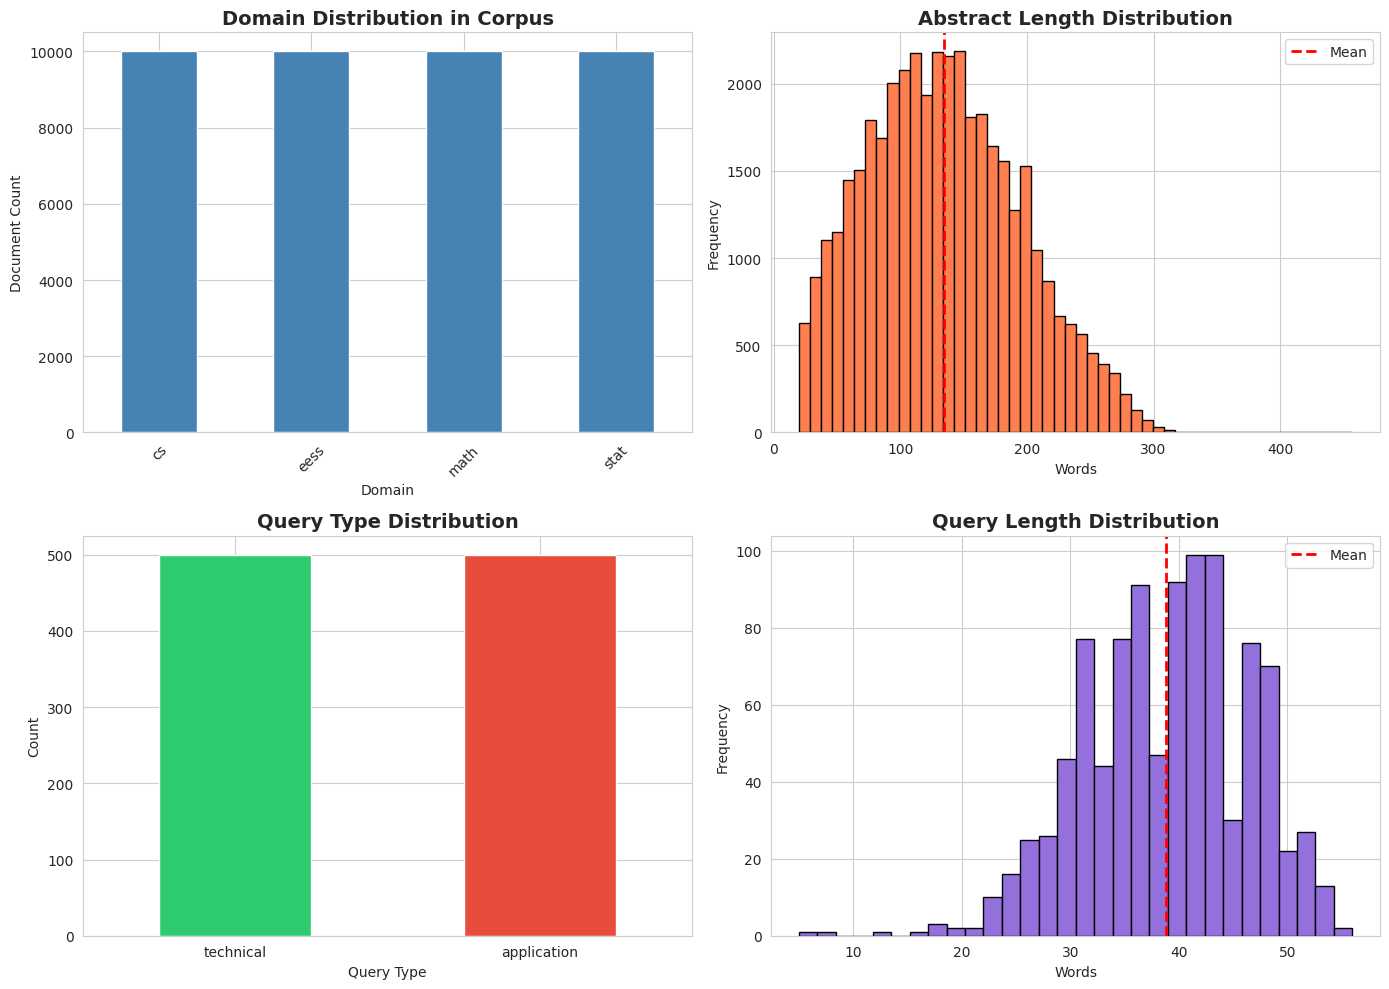

✓ Visualization saved as 'dataset_overview.png'


In [10]:
# --- OPTIONAL: QUICK DATA EXPLORATION ---
import matplotlib.pyplot as plt
import seaborn as sns

# Load data and RECOMPUTE computed columns
corpus_df = pd.read_json("working_corpus.jsonl", lines=True, dtype={'id': str})
eval_df = pd.read_json("rag_eval_set.json")
corpus_stats = json.load(open("corpus_statistics.json"))
query_stats = json.load(open("query_statistics.json"))

# Recompute abstract_length (it's not saved in the JSONL)
corpus_df['abstract_length'] = corpus_df['abstract'].str.split().str.len()
eval_df['query_length'] = eval_df['query'].str.split().str.len()

# Extract primary domain
def get_primary_domain(cats):
    cats_list = cats[0].split() if isinstance(cats[0], str) else cats
    return cats_list[0].split('.')[0].split('-')[0]

corpus_df['primary_domain'] = corpus_df['categories'].apply(get_primary_domain)

# Now proceed with visualization
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Domain distribution in corpus
ax1 = axes[0, 0]
domain_counts = corpus_df['primary_domain'].value_counts().sort_index()
domain_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Domain Distribution in Corpus', fontsize=14, fontweight='bold')
ax1.set_xlabel('Domain')
ax1.set_ylabel('Document Count')
ax1.tick_params(axis='x', rotation=45)

# 2. Abstract length distribution
ax2 = axes[0, 1]
corpus_df['abstract_length'].hist(bins=50, ax=ax2, color='coral', edgecolor='black')
ax2.axvline(corpus_stats['abstract_length']['mean'], color='red', linestyle='--', linewidth=2, label='Mean')
ax2.set_title('Abstract Length Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Words')
ax2.set_ylabel('Frequency')
ax2.legend()

# 3. Query type distribution
ax3 = axes[1, 0]
query_type_counts = pd.Series(query_stats['queries_per_type'])
query_type_counts.plot(kind='bar', ax=ax3, color=['#2ecc71', '#e74c3c'])
ax3.set_title('Query Type Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Query Type')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=0)

# 4. Query length distribution
ax4 = axes[1, 1]
eval_df['query_length'].hist(bins=30, ax=ax4, color='mediumpurple', edgecolor='black')
ax4.axvline(query_stats['query_length']['mean'], color='red', linestyle='--', linewidth=2, label='Mean')
ax4.set_title('Query Length Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Words')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.savefig('dataset_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'dataset_overview.png'")

### Backup: Download Dataset Artifacts

Package all generated files into a zip archive for local backup and use in the main RAG experimentation notebook.

**Files Included:**
- `working_corpus.jsonl` (40k documents)
- `rag_eval_set.json` (1k queries)
- `corpus_statistics.json` (metadata)
- `query_statistics.json` (metadata)
- `dataset_overview.png` (visualization)

**Usage:** Upload this zip to your main RAG notebook to skip dataset generation.

---

In [11]:
from google.colab import files
import zipfile
import os

# Files you want to persist
files_to_save = [
    "working_corpus.jsonl",
    "rag_eval_set.json",
    "corpus_statistics.json",
    "query_statistics.json",
    "dataset_overview.png",
]

zip_name = "rag_artifacts_backup.zip"

# Create zip
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as z:
    for f in files_to_save:
        if os.path.exists(f):
            z.write(f)
        else:
            print(f"⚠️ Missing file: {f}")

# Trigger download
files.download(zip_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Load Data

### Data Loading Cell - Flexible Import System

This cell automatically locates and loads the RAG dataset files from multiple possible locations:
- Current directory (continuous execution)
- `/content` (Colab default upload location)
- Google Drive (if mounted)
- Local downloads folder

**Smart Features:**
✅ Searches multiple paths automatically  
✅ Validates data integrity after loading  
✅ Reports missing files with clear instructions  
✅ Verifies ground truth and hard negative coverage

**Expected Output:**
- `corpus_df`: 40,000 document DataFrame
- `eval_df`: 1,000 query DataFrame  
- `corpus_stats`: Corpus metadata dictionary
- `query_stats`: Query metadata dictionary

---

💡 **Pro Tip:** This cell can be placed at the start of your RAG experimentation notebook, allowing you to skip the dataset generation steps entirely!

---

In [2]:
# =============================================================================
# DATA LOADING CELL - Works for both fresh upload and continuous execution
# =============================================================================

import os
import json
import pandas as pd
from pathlib import Path

print("="*70)
print("LOADING RAG DATASET")
print("="*70)

# Define expected files
REQUIRED_FILES = {
    'corpus': 'working_corpus.jsonl',
    'eval_set': 'rag_eval_set.json',
    'corpus_stats': 'corpus_statistics.json',
    'query_stats': 'query_statistics.json'
}

# Try to find files in multiple locations
def find_file(filename):
    """Search for file in common Colab locations"""
    search_paths = [
        Path('.'),                          # Current directory (if continuous execution)
        Path('/content'),                   # Colab default
        Path('/content/drive/MyDrive'),     # Google Drive mount
        Path.home() / 'Downloads',          # Local downloads
    ]

    for path in search_paths:
        file_path = path / filename
        if file_path.exists():
            return str(file_path)
    return None

# Locate all files
file_paths = {}
missing_files = []

for key, filename in REQUIRED_FILES.items():
    path = find_file(filename)
    if path:
        file_paths[key] = path
        print(f"✓ Found {filename}")
    else:
        missing_files.append(filename)
        print(f"✗ Missing {filename}")

# Handle missing files
if missing_files:
    print(f"\n{'='*70}")
    print("ERROR: Missing required files!")
    print(f"{'='*70}")
    print("\nPlease upload the following files to your Colab environment:")
    for f in missing_files:
        print(f"  - {f}")
    print("\nYou can drag and drop them into the 'Files' panel on the left.")
    raise FileNotFoundError(f"Missing files: {missing_files}")

# Load data
print(f"\n{'='*70}")
print("LOADING DATA INTO MEMORY")
print(f"{'='*70}\n")

# Load corpus
print("Loading corpus...")
corpus_df = pd.read_json(file_paths['corpus'], lines=True, dtype={'id': str})
print(f"  ✓ Loaded {len(corpus_df):,} documents")

# Load eval set
print("Loading evaluation set...")
with open(file_paths['eval_set'], 'r') as f:
    eval_set = json.load(f)
eval_df = pd.DataFrame(eval_set)
print(f"  ✓ Loaded {len(eval_df):,} queries")

# Load statistics
print("Loading statistics...")
with open(file_paths['corpus_stats'], 'r') as f:
    corpus_stats = json.load(f)
with open(file_paths['query_stats'], 'r') as f:
    query_stats = json.load(f)
print(f"  ✓ Statistics loaded")

# Data validation
print(f"\n{'='*70}")
print("DATA VALIDATION")
print(f"{'='*70}\n")

# Check corpus integrity
assert len(corpus_df) == corpus_stats['total_documents'], "Corpus size mismatch!"
print(f"✓ Corpus size validated: {len(corpus_df):,} documents")

# Check eval set integrity
assert len(eval_df) == query_stats['total_queries'], "Eval set size mismatch!"
print(f"✓ Eval set size validated: {len(eval_df):,} queries")

# Check ground truth coverage
corpus_ids = set(corpus_df['id'].astype(str))
eval_gt_ids = set(eval_df['ground_truth_id'].astype(str))
missing_gt = eval_gt_ids - corpus_ids
print(f"✓ Ground truth coverage: {len(eval_gt_ids - missing_gt)}/{len(eval_gt_ids)} found")

if missing_gt:
    print(f"  ⚠ Warning: {len(missing_gt)} ground truth IDs not in corpus")

# Check hard negatives coverage
all_hard_negs = set()
for row in eval_df.itertuples():
    all_hard_negs.update(row.hard_negative_ids)
missing_hn = all_hard_negs - corpus_ids
print(f"✓ Hard negatives coverage: {len(all_hard_negs - missing_hn)}/{len(all_hard_negs)} found")

if missing_hn:
    print(f"  ⚠ Warning: {len(missing_hn)} hard negative IDs not in corpus")

# Display summary statistics
print(f"\n{'='*70}")
print("DATASET SUMMARY")
print(f"{'='*70}\n")

print("Corpus:")
print(f"  Documents: {corpus_stats['total_documents']:,}")
print(f"  Domains: {list(corpus_stats['domain_distribution'].keys())}")
print(f"  Avg abstract length: {corpus_stats['abstract_length']['mean']:.1f} words")
print(f"  Unique categories: {corpus_stats['unique_categories']}")

print("\nEvaluation Set:")
print(f"  Total queries: {query_stats['total_queries']}")
print(f"  Technical queries: {query_stats['queries_per_type']['technical']}")
print(f"  Application queries: {query_stats['queries_per_type']['application']}")
print(f"  Avg query length: {query_stats['query_length']['mean']:.1f} words")
print(f"  Hard negatives per query: {query_stats['hard_negatives_per_query']}")

print(f"\n{'='*70}")
print("✓ DATA LOADING COMPLETE - Ready for experimentation!")
print(f"{'='*70}\n")

# Make data easily accessible
print("Available variables:")
print("  - corpus_df: Pandas DataFrame with corpus documents")
print("  - eval_df: Pandas DataFrame with evaluation queries")
print("  - corpus_stats: Dictionary with corpus statistics")
print("  - query_stats: Dictionary with query statistics")

LOADING RAG DATASET
✓ Found working_corpus.jsonl
✓ Found rag_eval_set.json
✓ Found corpus_statistics.json
✓ Found query_statistics.json

LOADING DATA INTO MEMORY

Loading corpus...
  ✓ Loaded 40,000 documents
Loading evaluation set...
  ✓ Loaded 1,000 queries
Loading statistics...
  ✓ Statistics loaded

DATA VALIDATION

✓ Corpus size validated: 40,000 documents
✓ Eval set size validated: 1,000 queries
✓ Ground truth coverage: 500/500 found
✓ Hard negatives coverage: 3450/3450 found

DATASET SUMMARY

Corpus:
  Documents: 40,000
  Domains: ['math', 'cs', 'stat', 'eess']
  Avg abstract length: 134.4 words
  Unique categories: 151

Evaluation Set:
  Total queries: 1000
  Technical queries: 500
  Application queries: 500
  Avg query length: 38.8 words
  Hard negatives per query: 5

✓ DATA LOADING COMPLETE - Ready for experimentation!

Available variables:
  - corpus_df: Pandas DataFrame with corpus documents
  - eval_df: Pandas DataFrame with evaluation queries
  - corpus_stats: Dictionary 